# Analyzing the MCMC Accuracy Results

## Average WIS by State
We have weekly prediction data for each state. To start comparing the results, we will plot the average of each state's scores for a visual comparison. 

In [12]:
# Create a dataframe where each state has a single average WIS score
import pandas as pd
import os

all_data = pd.DataFrame(columns=['state_code', 'state_abbrev', 'avg_wis'])

accuracy_results_path = '../mcmc_accuracy_results/'
for file_name in os.listdir(accuracy_results_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(accuracy_results_path, file_name)
        state_df = pd.read_csv(file_path)
        state_code, state_abbrev = state_df['state_code'][1], state_df['state_abbrev'][1]
        all_wis_columns = ['1wk_WIS', '2wk_WIS', '3wk_WIS', '4wk_WIS']
        combined_data = state_df[all_wis_columns].values.flatten()
        avg_wis = combined_data.mean()
        new_row = {'state_code': str(state_code).zfill(2), 'state_abbrev': state_abbrev, 'avg_wis': avg_wis}
        new_row_df = pd.DataFrame([new_row], columns=['state_code', 'state_abbrev', 'avg_wis'])
        all_data = pd.concat([all_data, new_row_df], ignore_index=True)

all_data.head()

/tmp/ipykernel_50483/2345187149.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, new_row_df], ignore_index=True)


,state_code,state_abbrev,avg_wis
0,04,AZ,321.177188
1,01,AL,76.918125
2,05,AR,81.767187
3,06,CA,440.165417
4,08,CO,104.970208


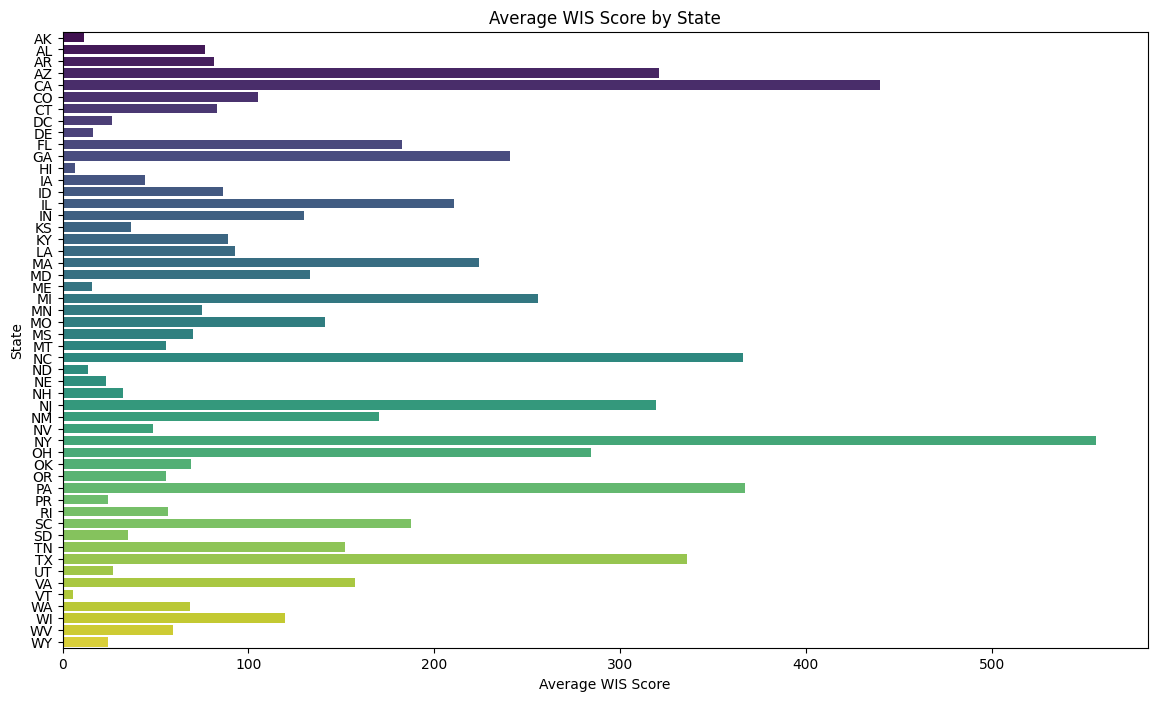

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(14, 8))

# Create bar plot
all_data.sort_values(by='state_abbrev', ascending=True, inplace=True)
sns.barplot(x='avg_wis', y='state_abbrev', data=all_data, palette='viridis', hue='state_abbrev', legend=False)

# Add title and labels
plt.title('Average WIS Score by State')
plt.xlabel('Average WIS Score')
plt.ylabel('State')

# Show plot
plt.show()


Not too enlightening. Let's try to find features that are influencing the big difference in scores between states.

In [ ]:
# 